In [2]:
import sys
sys.path.append("/workspaces/nyu-hedge-fund-strategies")

In [39]:
import nasdaqdatalink as quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sharadar import equity_prices

In [4]:
quandl.ApiConfig.api_key = 'NRvcyMwNMXZ2ooDSM3nw'
universe = quandl.get_table('SHARADAR/SP500', action='current')
universe.head()

,date,action,ticker,name,contraticker,contraname,note
None,,,,,,,
0,2023-10-14,current,ZTS,ZOETIS INC,N/A,N/A,None
1,2023-10-14,current,ZION,ZIONS BANCORPORATION NATIONAL ASSOCIATION,N/A,N/A,None
2,2023-10-14,current,ZBRA,ZEBRA TECHNOLOGIES CORP,N/A,N/A,None
3,2023-10-14,current,ZBH,ZIMMER BIOMET HOLDINGS INC,N/A,N/A,None
4,2023-10-14,current,YUM,YUM BRANDS INC,N/A,N/A,None


In [5]:
fundamentals = quandl.get_table('SHARADAR/SF1', datekey={'gte':'2023-03-31','lte':'2023-08-31'}, dimension="ART", ticker=",".join(universe['ticker'].to_list()))
fundamentals = fundamentals.drop_duplicates("ticker", keep="first")
fundamentals.head()

,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,...,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital
None,,,,,,,,,,,,,,,,,,,,,
0,ZTS,ART,2023-06-30,2023-08-08,2023-06-30,2023-08-08,-895000000,13749000000,1.402550e+10,6.183000e+09,...,460316905,461900000,462900000.0,17.800,9783000000,192000000,619000000.0,486000000,21.180,4.414000e+09
2,ZION,ART,2023-06-30,2023-08-04,2023-06-30,2023-08-07,-2930000000,87230000000,8.845550e+10,NaN,...,148145133,147692000,147696000.0,21.091,86168000000,0,265000000.0,0,583.430,NaN
4,ZBRA,ART,2023-06-30,2023-08-01,2023-07-01,2023-08-01,-60000000,7456000000,7.476750e+09,1.753000e+09,...,51338364,51338364,NaN,107.132,2983000000,461000000,153000000.0,91000000,58.105,-1.700000e+07
6,ZBH,ART,2023-06-30,2023-08-01,2023-06-30,2023-08-01,-177800000,21294300000,2.123428e+10,4.387900e+09,...,208964134,208600000,209900000.0,34.494,7522900000,0,159800000.0,932200000,36.064,2.154200e+09
8,YUM,ART,2023-06-30,2023-08-07,2023-06-30,2023-08-07,-293000000,5848000000,5.805500e+09,1.515000e+09,...,280211281,280211281,NaN,24.949,4838000000,821000000,303000000.0,50000000,17.266,2.800000e+07


In [25]:
fundamentals.sort_values("datekey", inplace=True)
fundamentals["OneDRet"] = 0.0
fundamentals["FiveDRet"] = 0.0
fundamentals["TwentyOneDRet"] = 0.0
datekeys = fundamentals["datekey"].unique()
for d in datekeys:
    tickers = fundamentals[fundamentals["datekey"] == d]["ticker"].to_list()
    df = equity_prices.get_price_daterange(tickers, d)
    for t in tickers:
        tdf = df[df["ticker"] == t]
        if not tdf.empty:
            tdf.sort_values("date", inplace=True)
            fundamentals.loc[fundamentals["ticker"] == t, "OneDRet"] = tdf.iloc[1]["closeadj"] / tdf.iloc[0]["closeadj"] - 1
            fundamentals.loc[fundamentals["ticker"] == t, "FiveDRet"] = tdf.iloc[5]["closeadj"] / tdf.iloc[0]["closeadj"] - 1
            fundamentals.loc[fundamentals["ticker"] == t, "TwentyOneDRet"] = tdf.iloc[-1]["closeadj"] / tdf.iloc[0]["closeadj"] - 1

/tmp/ipykernel_1446/2607361539.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf.sort_values("date", inplace=True)


In [27]:
df = pd.merge(left=universe, right=fundamentals, left_on="ticker", right_on="ticker", how="left")
df[df["datekey"].isna()]
# Sharadar only supports primary share query

,date,action,ticker,name,contraticker,contraname,note,dimension,calendardate,datekey,...,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,OneDRet,FiveDRet,TwentyOneDRet
160,2023-10-14,current,NWS,NEWS CORP,N/A,N/A,None,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
294,2023-10-14,current,GOOG,ALPHABET INC,N/A,N/A,None,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,2023-10-14,current,FOX,FOX CORP,N/A,N/A,None,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
revenue = fundamentals.revenue
fundamentals["operating_margin"] = fundamentals.opinc / revenue.where(revenue > 0)
# exclude companies with negative operating expenses or negative cost of revenue
opex = fundamentals.opex
cor = fundamentals.cor
fundamentals["operating_margin"] = fundamentals["operating_margin"].where((opex > 0) & (cor > 0))
# clip range to (-1, 1) so as not to overweight outliers
fundamentals["operating_margin"] = fundamentals["operating_margin"].clip(-1, 1)
# The formula for the Fama-French profitability factor using Sharadar fields is: (REVENUE - COR - INTEXP - SGNA) / EQUITY.

In [29]:
fundamentals["operating_margin"].describe()

count    458.000000
mean       0.170883
std        0.154976
min       -1.000000
25%        0.091912
50%        0.161193
75%        0.247400
max        0.868417
Name: operating_margin, dtype: float64

In [30]:
negative_opermargin = fundamentals[fundamentals["operating_margin"] <= 0]["operating_margin"]
twenty_five_percentile = np.nanpercentile(negative_opermargin, 50)
first_quantile = negative_opermargin[negative_opermargin <= twenty_five_percentile]
second_quantile = negative_opermargin[negative_opermargin > twenty_five_percentile]

positive_opermargin = fundamentals[fundamentals["operating_margin"] > 0]["operating_margin"]
seventy_five_percentile = np.nanpercentile(positive_opermargin, 50)
third_quantile = positive_opermargin[positive_opermargin <= seventy_five_percentile]
forth_quantile = positive_opermargin[positive_opermargin > seventy_five_percentile]

In [31]:
days_count = 1
total_count = len(fundamentals["operating_margin"])
factor_quantile = {"Factor Quantile": ["1 (most negative)", "2", "3", "4 (most negative)"],
 "min": [min(first_quantile), min(second_quantile), min(third_quantile), min(forth_quantile)],
 "max": [max(first_quantile), max(second_quantile), max(third_quantile), max(forth_quantile)],
 "mean": [np.mean(first_quantile), np.mean(second_quantile), np.mean(third_quantile), np.mean(forth_quantile)],
 "std": [np.std(first_quantile), np.std(second_quantile), np.std(third_quantile), np.std(forth_quantile)],
 "count": [len(first_quantile), len(second_quantile), len(third_quantile), len(forth_quantile)],
 "avg daily count": [len(first_quantile) / days_count, len(second_quantile) / days_count, len(third_quantile) / days_count, len(forth_quantile) / days_count],
 "count %": [len(first_quantile) / total_count, len(second_quantile) / total_count, len(third_quantile) / total_count, len(forth_quantile) / total_count]}

In [32]:
factor_quantile_df = pd.DataFrame(factor_quantile)
factor_quantile_df.set_index("Factor Quantile", inplace=True)
pd.set_option('display.precision', 3)
factor_quantile_df

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1 (most negative),-1.000,-0.071,-0.276,0.292,13,13.0,0.026
2,-0.070,-0.014,-0.035,0.017,13,13.0,0.026
3,0.004,0.169,0.099,0.046,216,216.0,0.432
4 (most negative),0.170,0.868,0.282,0.107,216,216.0,0.432


In [38]:
firstq_returns = fundamentals[fundamentals["operating_margin"] <= twenty_five_percentile][["OneDRet", "FiveDRet", "TwentyOneDRet"]].median()
secondq_returns = fundamentals[(fundamentals["operating_margin"] > twenty_five_percentile) & (fundamentals["operating_margin"] <= 0) ][["OneDRet", "FiveDRet", "TwentyOneDRet"]].median()
thirdq_returns = fundamentals[(fundamentals["operating_margin"] > 0) & (fundamentals["operating_margin"] <= seventy_five_percentile) ][["OneDRet", "FiveDRet", "TwentyOneDRet"]].median()
forthq_returns = fundamentals[(fundamentals["operating_margin"] > seventy_five_percentile) ][["OneDRet", "FiveDRet", "TwentyOneDRet"]].median()

In [40]:
one_day_returns = [firstq_returns[0], secondq_returns[0], thirdq_returns[0], forthq_returns[0]]
five_day_returns = [firstq_returns[1], secondq_returns[1], thirdq_returns[1], forthq_returns[1]]
twentyone_day_returns = [firstq_returns[2], secondq_returns[2], thirdq_returns[2], forthq_returns[2]]

/tmp/ipykernel_1446/2981877852.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  one_day_returns = [firstq_returns[0], secondq_returns[0], thirdq_returns[0], forthq_returns[0]]
/tmp/ipykernel_1446/2981877852.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  five_day_returns = [firstq_returns[1], secondq_returns[1], thirdq_returns[1], forthq_returns[1]]
/tmp/ipykernel_1446/2981877852.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

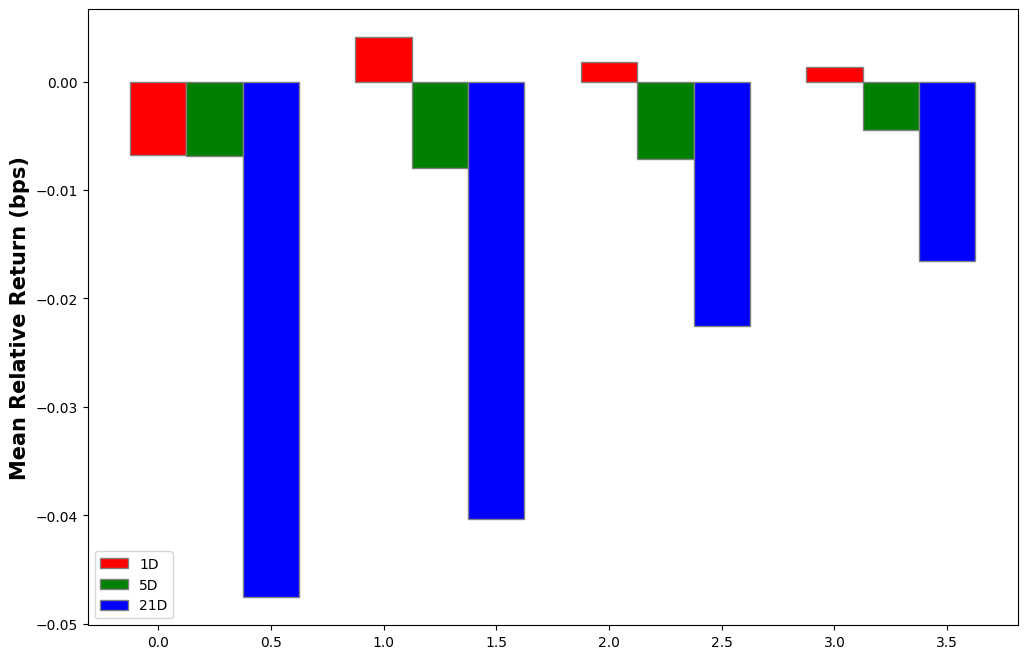

In [41]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(one_day_returns)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1, one_day_returns, color ='r', width = barWidth, edgecolor ='grey', label ='1D') 
plt.bar(br2, five_day_returns, color ='g', width = barWidth, edgecolor ='grey', label ='5D') 
plt.bar(br3, twentyone_day_returns, color ='b', width = barWidth, edgecolor ='grey', label ='21D')
plt.ylabel('Mean Relative Return (bps)', fontweight ='bold', fontsize = 15) 
plt.legend()
plt.show()